# Reinforcement Learning - Artificial Intelligence example

###### CocaCola stock market data (Yahoo) https://finance.yahoo.com/quote/KO/history?p=KO

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")
from rl_utils import *
from IPython import display

ModuleNotFoundError: No module named 'gym'

###### Import data

In [ ]:
dtf = pd.read_csv("data.txt")
dtf = dtf.set_index("Date").drop("OpenInt", axis=1)
dtf.head()

In [ ]:
dtf.tail()

In [ ]:
dtf.info()

###### Create / Load env

In [5]:
class NewEnv(gym.Env):
    metadata = {'render.modes':['human','rgb_array','html'], 'video.frames_per_second':30}
    
    '''
    Define initial parameters of the env:
        - states_space_type: str - "array" or "img"
        - states_space: gym.spaces array - array (2d:[x,y] or 3d:[x,y,z]) or tensor (base,altezza,rgb_channels)
        - actions_space_type: str - "discrete" or "continuous"
        - actions_space: gym.spaces int - 3 (buy, hold, sell) or array
        - reward_range: tuple - (-np.inf, np.inf) or (-1, 1)
        - goal: can be anything (value to reach, position in the states_space, number of steps to do)
        - data: dtf 
    '''
    def __init__(self, states_space_type, actions_space_type, data, name):
        super(NewEnv, self).__init__()
        
        self.states_names = ["Open","High","Low","Close","Volume","Balance","N shares held","Last price used"]
        
        if states_space_type == "array":
            self.states_space = gym.spaces.Box(low=0, high=1, shape=(len(self.states_names),len(self.states_names)), dtype=np.float16)
        elif states_space_type == "img":
            self.states_space = gym.spaces.Box(low=0, high=255, shape=(255,255,3), dtype=np.uint8)
            
        self.actions_names = ["Buy","Sell","Hold"]
        
        if actions_space_type == "discrete":
            self.actions_space = gym.spaces.Discrete(len(self.actions_names))
        elif actions_space_type == "continuous":
            self.actions_space = gym.spaces.Box(low=np.array([0,0]), high=np.array([3,1]), dtype=np.float16)
        
        self.reward_range = (-np.inf, np.inf)
        self.goal = None
        self.data = data
        print("env:", name, "| states_space:", self.states_space.shape[0], 
              "| actions_space:", self.actions_space.n, "| reward:", self.reward_range, "| goal:", self.goal)
        
    
    '''
    Reset the state of the env to an initial state and set the current step to a random point within the data.
    '''
    def reset(self):
        self.balance, self.action_cost, self.N, self.P0 = 100, 1, 0, None
        self.current_step = random.randint(0, len(self.data)-250)
        return self.__state__()
    
    
    '''
    Get new state after action or reset.
    '''
    def __state__(self):
        state = np.append(self.data.iloc[self.current_step].values, [[self.balance, self.N, self.P0]])
        return state
    
    
    '''
    Take the action.
    '''
    def __take_action__(self, action):
        self.P1 = self.data["Close"].iloc[self.current_step]
        ## buy
        if action == 0:
            self.balance = self.balance - self.P1 - self.action_cost
            self.N += 1
        ## sell
        elif action == 1:
            self.balance = self.balance + self.P1 - self.action_cost
            self.N -= 1
        ## hold
        elif action == 2:
            None
    
    
    '''
    Compute reward after action.
    '''
    def __reward__(self):
        if self.balance > 0:
            reward = 1
        elif self.balance < 0:
            reward = -1
        else:
            reward = 0
        return reward
    
    
    '''
    Decide whether the episode is done after action.
    '''
    def __done__(self):
        done = False
        ## done by time limit
        if self.current_step == 250:
            done = True
        ## done by failed task
        elif self.balance < 0:
            done = True
        return done
    
    
    '''
    Log info after action.
    '''
    def __info__(self):
        info = {}
        ## done by time limit
        if self.current_step == 250:
            info.update( {"time":"250 days have passed"} )
        ## done by failed task
        elif self.balance < 0:
            info.update( {"balance":"broke"} )
        return info
    
    
    '''
    Execute one time step based on action.
    '''
    def step(self, action):
        assert self.actions_space.contains(action), "%r (%s) invalid" % (action, type(action))
        self.__take_action__(action)
        self.current_step += 1
        return self.__state__(), self.__reward__(), self.__done__(), self.__info__()
        
        
    '''
    Display as animation on jupyter notebook.
    Return matplotlib animation object then --> IPython.display.HTML(env.render("html").to_html5_video())
    '''
    def __render_html__(self):
        
        fig, ax = plt.subplots()
        ax.set(xlim=(0,2), ylim=(-2,2))
        line, = ax.plot([], [], lw=2)
        
        def __animate__(i):
            x = np.linspace(0, 2, 1000)
            y = np.sin(2 * np.pi * (x-0.01*i))
            line.set_data(x, y)
            return (line,)
        
        anim = anm.FuncAnimation(fig, __animate__, frames=100, interval=20, blit=True)
        plt.close()
        return anim
    
    
    '''
    Display as
    '''
    def __render_human__(self):
        pass
    
    
    '''
    Render the agent in the env to the screen.
    '''
    def render(self, mode='human', close=False):
        if mode == "human":
            return self.__render_human__()
        elif mode == "html":
            return self.__render_html__()

In [6]:
env = NewEnv(name="TradingEnv", data=dtf, states_space_type="array", actions_space_type="discrete")

env: TradingEnv | states_space: 8 | actions_space: 3 | reward: (-inf, inf) | goal: None


In [7]:
env.reset()

array([17.86, 17.898, 17.697, 17.712, 13986400.0, 100, 0, None],
      dtype=object)

### 1 - Environment Analysis

###### Space

In [17]:
env_info(env, rendering="html")

--- states space ---
dim: Box(8, 8)
names: ['Open', 'High', 'Low', 'Close', 'Volume', 'Balance', 'N shares held', 'Last price used']
--- actions space ---
dim: Discrete(3)
names: ['Buy', 'Sell', 'Hold']
--- goal ---
goal: Don't die


###### Rendering

In [18]:
display.HTML( env.render("html").to_html5_video() )

###### Random play

In [13]:
dtf_random_play = env_random_play(env, episodes=10, rendering=False)

dtf_random_play.tail()

,episode,steps,state,reward,cumulated_reward,done,info,goal
17198,100,187,"[1.1909, 1.2072, 1.1909, 1.2072, 1671128.0, 1....",1,187,False,{},None
17199,100,188,"[1.2072, 1.2072, 1.1909, 1.1909, 976788.0, 1.3...",1,188,False,{},None
17200,100,189,"[1.1909, 1.2114, 1.1909, 1.2072, 1141547.0, 1....",1,189,False,{},None
17201,100,190,"[1.2153, 1.2317, 1.2153, 1.2317, 3471713.0, 1....",1,190,False,{},None
17202,100,191,"[1.2317, 1.2317, 1.2237, 1.2237, 1282768.0, -0...",-1,189,True,{'balance': 'broke'},None


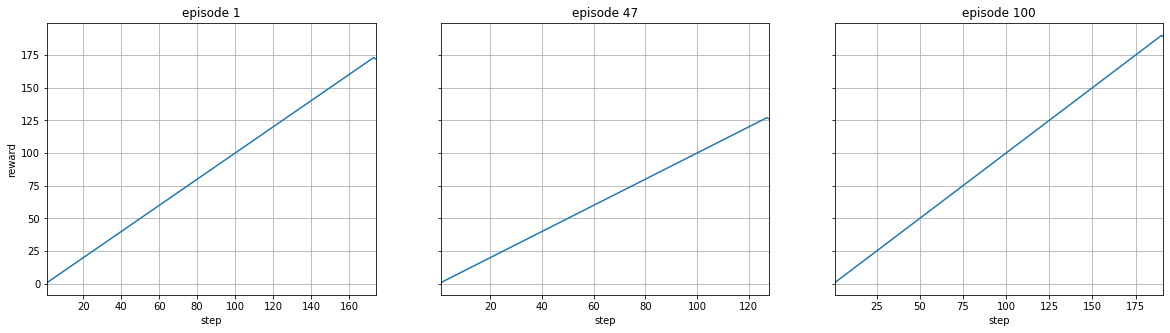

In [14]:
plot_logs(dtf_random_play, figsize=(20,5))

### 2 - Preprocessing

###### Partitioning

In [105]:
dtf_train = dtf[dtf.index[0]:"2017-01-01"]
dtf_train.tail(3)

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-28,40.469,40.645,40.372,40.372,9059060
2016-12-29,40.362,40.664,40.362,40.576,7048642
2016-12-30,40.664,40.810,40.332,40.440,11759488


In [107]:
dtf_test = dtf["2017-01-01":dtf.index[-1]]
dtf_test.head(3)

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,40.479,40.782,40.265,40.772,15060167
2017-01-04,40.850,40.937,40.566,40.626,10193183
2017-01-05,40.636,40.830,40.504,40.723,9194396


### 3 - Baseline (q-learning)

###### Train

###### Evaluate

### 4 - Model Desing & Testing (deep q-learning)

###### Train

###### Evaluate